In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier 

In [86]:
df = pd.read_csv("sgemm_product.csv")
df["RunF"]= (df["Run1 (ms)"] + df["Run2 (ms)"]+ df["Run3 (ms)"]+df["Run4 (ms)"])/4
df=df.drop(columns=['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'])
df['RunF'].mean()
df['RunF_binary'] = np.where(df['RunF']>=217.5, 1, 0)
train,test = train_test_split(df,test_size = 0.3, random_state=5000)
x_train= train.iloc[:,0:14]
y_train= train.iloc[:,-1]
x_test= test.iloc[:,0:14]
y_test= test.iloc[:,-1]



In [3]:
df2 = pd.read_csv("voice.csv")
np.sum(df2['label'] == 'male')
df2['label'] = np.where(df2['label']=='male', 1, 0)
df2['label'] 
np.sum(df2['label'] == 1)
train2,test2 = train_test_split(df2,test_size = 0.4, random_state=100)
x_train2= train2.iloc[:,0:20]
y_train2= train2.iloc[:,-1]
x_test2= test2.iloc[:,0:20]
y_test2= test2.iloc[:,-1]

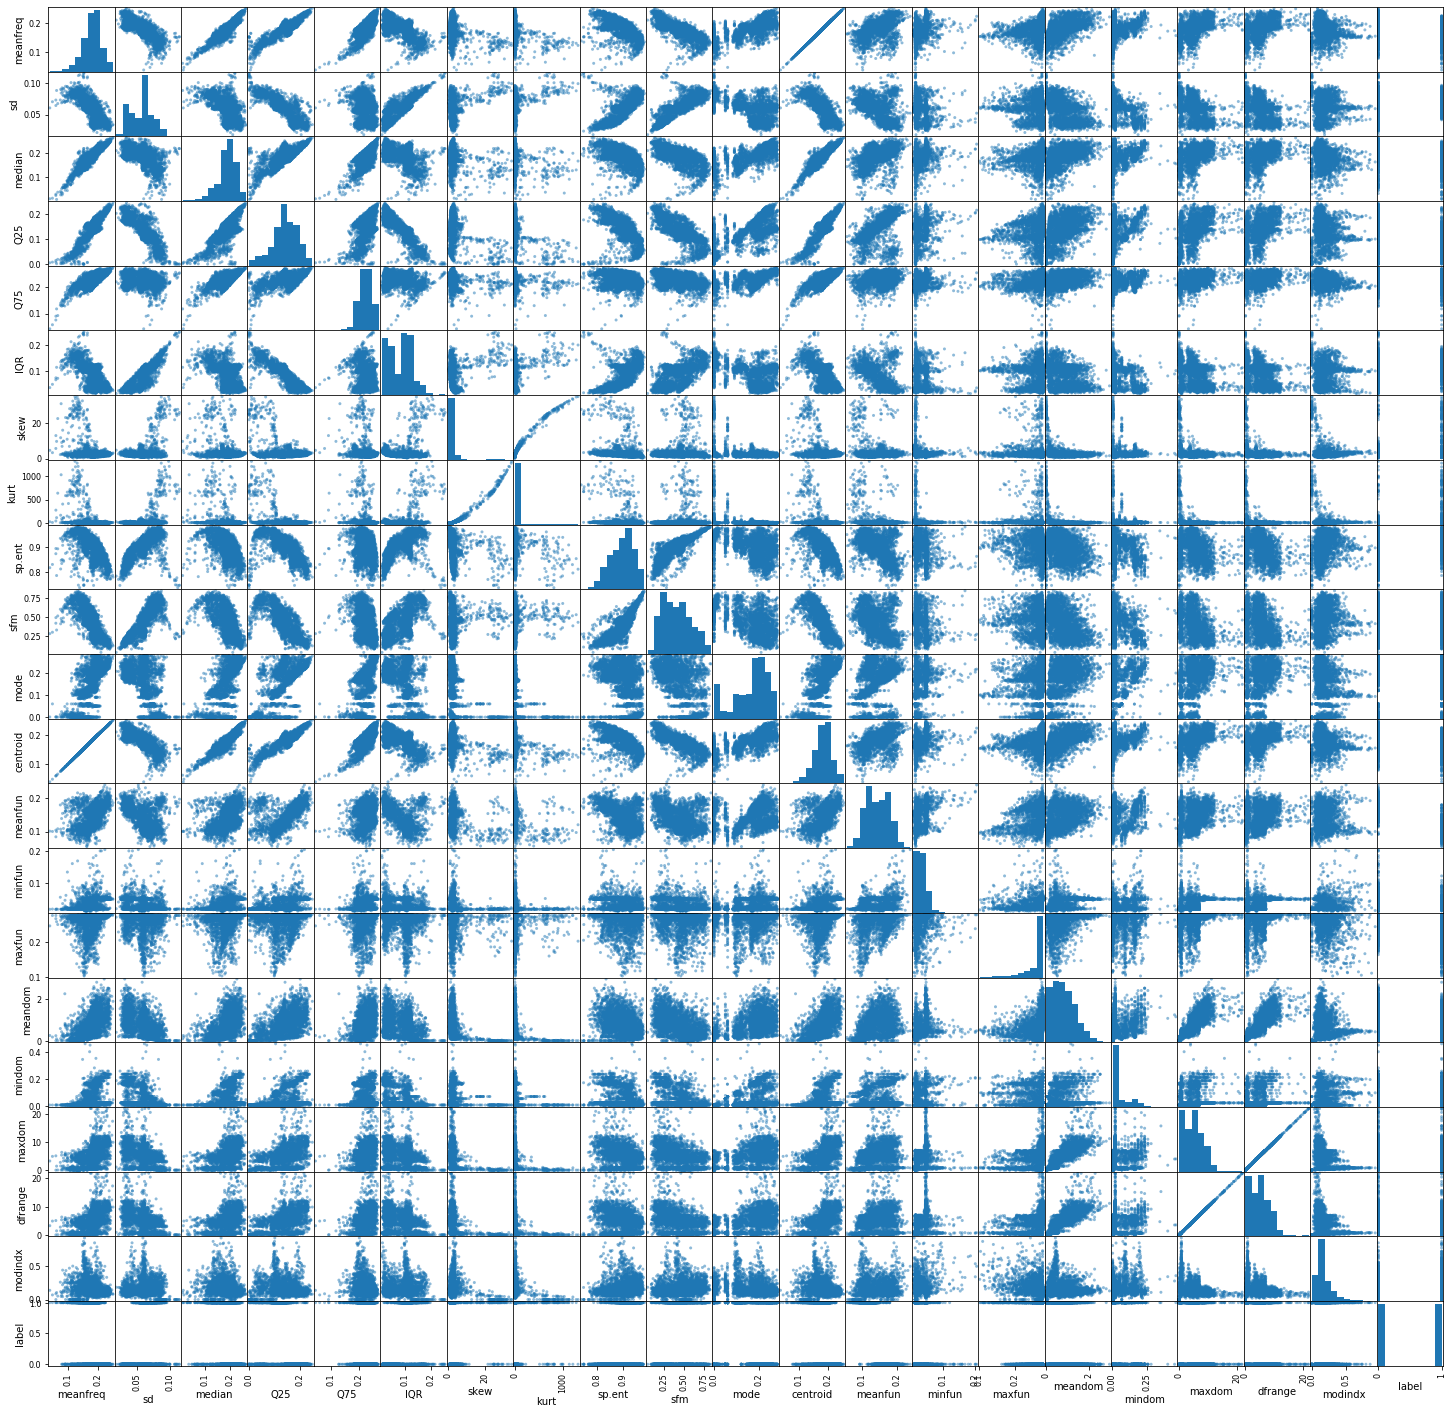

In [5]:
from pandas.plotting import scatter_matrix
p=scatter_matrix(df2,figsize=(25, 25))

In [84]:
print('GPU data has rows',len(df),'Voice data has rows', len(df2))

GPU data has rows 241600 Voice data has rows 3168


In [4]:
#xs should remind that the data needs to be trained
def KNNfun(k_range,Xs_tr,y_tr,Xs_ts,y_ts):
    acc_train=[]
    acc_test=[]
    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i,weights='uniform')
        knn.fit(Xs_tr,y_tr)
        pred_tr=knn.predict(Xs_tr)
        pred_ts=knn.predict(Xs_ts)
        acc_tr=knn.score(Xs_tr,y_tr)
        acc_ts=knn.score(Xs_ts,y_ts)
        acc_train.append(acc_tr)
        acc_test.append(acc_ts)      
    return acc_train, acc_test,pred_tr,pred_ts

In [5]:
k_range= range(19, 71, 2)
acc_plt2=KNNfun(k_range=k_range,Xs_tr= x_train2, y_tr=y_train2, Xs_ts=x_test2, y_ts=y_test2)



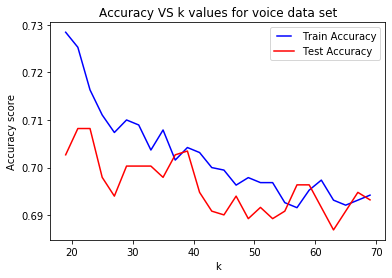

In [6]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(k_range, acc_plt2[0], 'b', label="Train Accuracy")
line2, = plt.plot(k_range, acc_plt2[1], 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("k")
plt.title("Accuracy VS k values for voice data set")
plt.show()


In [8]:
x_s_tr2 = (x_train2 - x_train2.mean())/x_train2.std()
x_s_ts2= (x_test2 - x_test2.mean())/x_test2.std()


In [13]:
k_range= range(1, 11, 2)
kacc_tr2,kacc_ts2,kpred2,kpred2=KNNfun(k_range=k_range,Xs_tr= x_s_tr2, y_tr=y_train2, Xs_ts=x_s_ts2, y_ts=y_test2)

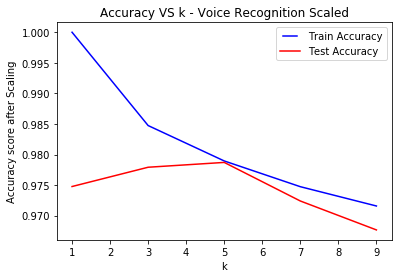

In [15]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(k_range, kacc_tr2, 'b', label="Train Accuracy")
line2, = plt.plot(k_range, kacc_ts2, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score after Scaling")
plt.xlabel("k")
plt.title("Accuracy VS k - Voice Recognition Scaled")
plt.show()

In [16]:
#create scaled x and y for entire voice data
x2=df2.iloc[:,0:20]
y2=df2.iloc[:,-1]
xs2=(x2 - x2.mean())/x2.std()


In [12]:
#Cross-validation for a Narrower Search
from sklearn.model_selection import GridSearchCV
#New knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.array(range(1,29,2))}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(xs2, y2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

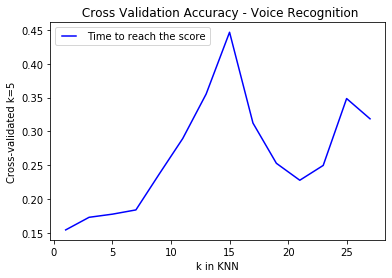

In [13]:
res2=pd.DataFrame(knn_gscv.cv_results_)
res2.head()
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(res2['param_n_neighbors'], res2['mean_score_time'], 'b', label="Time to reach the score")
#line2, = plt.plot(res2['param_n_neighbors'], res2['mean_test_score'], 'r', label="CV Mean Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Cross-validated k=5")
plt.xlabel("k in KNN")
plt.title(" Cross Validation Accuracy - Voice Recognition")
plt.show()

In [14]:
print('Best value of k is',knn_gscv.best_params_, 'with an accuracy of', knn_gscv.best_score_)

Best value of k is {'n_neighbors': 7} with an accuracy of 0.9479166666666666


In [48]:
#Scaling the x-variables for GPU
x_s_tr = (x_train - x_train.mean())/x_train.std()
df=df.sample(frac=1)

x=df.iloc[:,0:14]
y=df.iloc[:,-1]
x_s_ts= (x_test - x_test.mean())/x_test.std()
xs=(x - x.mean())/x.std()


In [51]:
xs.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
108695,-0.386524,-0.386524,0.825764,2.294244,-0.753892,-0.146029,-0.998052,-0.999998,-0.741447,2.841389,-0.999998,0.999998,0.999998,0.999998
129556,-0.386524,1.120450,0.825764,-0.753892,2.294244,-0.998052,-0.998052,-0.999998,2.841389,-0.741447,-0.999998,0.999998,-0.999998,-0.999998
229072,1.120450,1.120450,0.825764,0.262153,-0.753892,-0.998052,1.558017,0.999998,2.841389,-0.741447,-0.999998,-0.999998,-0.999998,-0.999998
83360,-0.386524,-1.140011,0.825764,0.262153,-0.753892,1.558017,-0.998052,-0.999998,-0.741447,0.794054,-0.999998,-0.999998,-0.999998,-0.999998
1608,-1.516754,-1.140011,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,0.999998,-0.741447,-0.741447,0.999998,-0.999998,-0.999998,-0.999998


In [17]:
 # Not run yet
#testing gpu for k=1 to 9 odd numbers
k_range= range(1, 11, 2)
acc_s_plt=KNNfun(k_range=k_range,Xs_tr= x_s_tr, y_tr=y_train, Xs_ts=x_s_ts, y_ts=y_test)


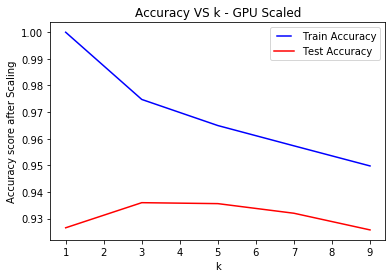

In [18]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(k_range, acc_s_plt[0], 'b', label="Train Accuracy")
line2, = plt.plot(k_range, acc_s_plt[1], 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score after Scaling")
plt.xlabel("k")
plt.title("Accuracy VS k - GPU Scaled")
plt.show()

In [52]:
#GPU Data
#Cross-validation for a Narrower Search 
#from sklearn.model_selection import GridSearchCV
#New knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.array(range(1,11,2))}
#use gridsearch to test all values for n_neighbors
knn_gscv1 = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv1.fit(xs, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 3, 5, 7, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
#After shuffling
knn_gscv1.cv_results_
#print('Best value of k is',knn_gscv1.best_params_, 'with an accuracy of', knn_gscv1.best_score_)

{'mean_fit_time': array([20.2320745 , 20.39202981, 21.23847818, 20.29136891, 20.10100007]),
 'std_fit_time': array([3.14856047, 3.44935863, 2.22156462, 2.95219636, 3.06296989]),
 'mean_score_time': array([19.20810008, 31.07947044, 41.59854035, 49.69764452, 57.32126641]),
 'std_score_time': array([0.31683501, 0.35519189, 1.49517643, 0.14483658, 0.27097825]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9}],
 'split0_test_score': array([0.9219387 , 0.93632168, 0.93762546, 0.93470748, 0.93156185]),
 'split1_test_score': array([0.92214565, 0.93671489, 0.93878438, 0.93491443, 0.93104447]),
 'split2_test_score': array([0.9227649 , 0.93652732, 0.93896937, 0.93468543, 0.93249172]),
 'split3_test_score': array([0.92512262, 0.93915437, 0.94037542, 0.93621557, 0.93

In [88]:
df.tail()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,RunF,RunF_binary
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.8175,0
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.0350,0
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.1600,0
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.4525,0
241599,128,128,32,32,32,32,32,8,4,4,1,1,1,1,17.8175,0


In [57]:
print('Best value of k is',knn_gscv1.best_params_, 'with an accuracy of', knn_gscv1.best_score_)

Best value of k is {'n_neighbors': 5} with an accuracy of 0.9387210264900663


In [18]:
#testing with changing seeds
t,t2 = train_test_split(df,test_size = 0.3, random_state=90000)
xt= t.iloc[:,0:14]
yt= t.iloc[:,-1]
xt2= t2.iloc[:,0:14]
yt2= t2.iloc[:,-1]
xt_sc = (xt - xt.mean())/xt.std()
xt2_sc=(xt2 - xt2.mean())/xt.std()
repk3=KNNfun(k_range=[3],Xs_tr= xt_sc, y_tr=yt, Xs_ts=xt2_sc, y_ts=yt2)

In [55]:
res=pd.DataFrame(knn_gscv1.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.232074,3.148560,19.208100,0.316835,1,{'n_neighbors': 1},0.921939,0.922146,0.922765,0.925123,0.919804,0.922355,0.001706,5
1,20.392030,3.449359,31.079470,0.355192,3,{'n_neighbors': 3},0.936322,0.936715,0.936527,0.939154,0.936050,0.936954,0.001122,2
2,21.238478,2.221565,41.598540,1.495176,5,{'n_neighbors': 5},0.937625,0.938784,0.938969,0.940375,0.937851,0.938721,0.000976,1
3,20.291369,2.952196,49.697645,0.144837,7,{'n_neighbors': 7},0.934707,0.934914,0.934685,0.936216,0.933877,0.934880,0.000756,3
4,20.101000,3.062970,57.321266,0.270978,9,{'n_neighbors': 9},0.931562,0.931044,0.932492,0.932283,0.932387,0.931954,0.000560,4


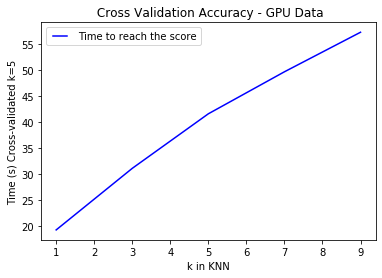

In [58]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(res['param_n_neighbors'], res['mean_score_time'], 'b', label="Time to reach the score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Time (s) Cross-validated k=5")
plt.xlabel("k in KNN")
plt.title(" Cross Validation Accuracy - GPU Data")
plt.show()

In [53]:
#using seed as 500 and 3 layers with 10 nodes each
from sklearn.neural_network import MLPClassifier
mlp2 = MLPClassifier(hidden_layer_sizes=[10, 10, 10], max_iter=1000,random_state=500)
mlp2.fit(x_train2, y_train2)
pred2 = mlp2.predict(x_test2)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test2,pred2))


[[585  42]
 [ 24 617]]


In [57]:
classification_report(y_test2,pred2)

'              precision    recall  f1-score   support\n\n           0       0.96      0.93      0.95       627\n           1       0.94      0.96      0.95       641\n\n    accuracy                           0.95      1268\n   macro avg       0.95      0.95      0.95      1268\nweighted avg       0.95      0.95      0.95      1268\n'

In [58]:
accuracy_score(y_test2,pred2)

0.9479495268138801

In [53]:
#Temporary variable for each experiment= cases

#Designing cases for number of nodes and number of layers
cases=[]
nodes= 10,30,50
layers=[3,5,10,15]
for node in nodes:
    for layer in layers:
        case=np.repeat(node, layer)
        cases.append(case)

In [41]:
for i in cases:
    print(i)

[10 10 10]
[10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[30 30 30]
[30 30 30 30 30]
[30 30 30 30 30 30 30 30 30 30]
[30 30 30 30 30 30 30 30 30 30 30 30 30 30 30]
[50 50 50]
[50 50 50 50 50]
[50 50 50 50 50 50 50 50 50 50]
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]


In [62]:
#relu activation and solver
def neuralwork(x_train,y_train,x_test,y_test):
    scores=[]
    pred=[]
    for i in cases:
        mlp = MLPClassifier(hidden_layer_sizes=i ,max_iter=1000,random_state=500)
        mlp.fit(x_train, y_train)
        prediction = mlp.predict(x_test)
        pred.append(prediction)
        acc=accuracy_score(y_test,prediction)
        scores.append(acc)
    return scores, pred


In [10]:
neural_acc2=neuralwork(x_train2,y_train2,x_test2,y_test2)

In [36]:
#5 layer 50 nodes relu activation accuracy
max(neural_acc2)

0.9526813880126183

In [38]:
#Best relu activation confusion matrix
bmlp2 = MLPClassifier(hidden_layer_sizes=[50, 50, 50, 50, 50],max_iter=1000,random_state=500)
bmlp2.fit(x_train2, y_train2)
bpred2 = bmlp2.predict(x_test2)
acc=accuracy_score(y_test2,bpred2)
print(confusion_matrix(y_test2,bpred2))


[[600  27]
 [ 33 608]]


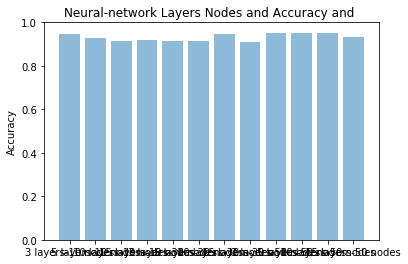

In [65]:
objects = ('3 layers-10 nodes', '5 layers-10 nodes', '10 layers-10 nodes','15 layers-10 nodes',
           '3 layers-30 nodes', '5 layers-30 nodes','10 layers-30 nodes', '15 layers-30 nodes',
          '3 layers-50 nodes', '5 layers-50 nodes', '10 layers-50 nodes', '15 layers-50 nodes',)
y_pos = np.arange(len(objects))

plt.bar(y_pos, neural_acc2, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Neural-network Layers Nodes and Accuracy and ')

plt.show()

In [69]:
#Neural Network with logistic activation and lbfgs solver. 
def logneuralwork(x_train,y_train,x_test,y_test):
    scores_l=[]
    pred_l=[]
    for i in cases:
        mlp = MLPClassifier(hidden_layer_sizes=i, activation='logistic', solver= 'lbfgs',max_iter=1000,random_state=500)
        mlp.fit(x_train, y_train)
        prediction = mlp.predict(x_test)
        acc=accuracy_score(y_test,prediction)
        scores_l.append(acc)
        pred_l.append(prediction)
    return scores_l,pred_l


In [18]:
neural_log_acc2=logneuralwork(x_train2,y_train2,x_test2,y_test2)

In [33]:
max(neural_log_acc2)

0.9613564668769716

In [40]:
#Best relu activation confusion matrix
bmlp2_log = MLPClassifier(hidden_layer_sizes=[10, 10, 10],activation='logistic', solver= 'lbfgs', max_iter=1000,random_state=500)
bmlp2_log.fit(x_train2, y_train2)
bpred2_log = bmlp2_log.predict(x_test2)
acc=accuracy_score(y_test2,bpred2_log)
print(confusion_matrix(y_test2,bpred2_log),acc)

[[592  35]
 [ 14 627]] 0.9613564668769716


In [63]:
#A new smaller set of cases for the GPU data
#Designing cases for number of nodes and number of layers
cases=[]
nodes= 3,6
layers=[1,5,10]
for node in nodes:
    for layer in layers:
        case=np.repeat(node, layer)
        cases.append(case)
for i in cases:
    print(i)

[3]
[3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3]
[6]
[6 6 6 6 6]
[6 6 6 6 6 6 6 6 6 6]


In [64]:
#Neural networks for GPU data relu and 
#use normalized
neural_acc, pred_nn=neuralwork(x_s_tr,y_train,x_s_ts,y_test)

In [65]:
neural_acc

[0.9323951434878587,
 0.9470336644591612,
 0.9459988962472407,
 0.9579332229580574,
 0.9656594922737307,
 0.9630656732891832]

In [74]:
#confusion matrix for relu activation function best preditiction of GPU NN
print(confusion_matrix(y_test,pred_nn[4]))


[[52009  1402]
 [ 1087 17982]]


In [75]:
#logistic activiation lggb solver neural network for GPU run time data
l_neural_acc, l_pred_nn=logneuralwork(x_s_tr,y_train,x_s_ts,y_test)

In [76]:
l_neural_acc

[0.9540976821192053,
 0.7369067328918323,
 0.7369067328918323,
 0.9611616997792495,
 0.7369067328918323,
 0.7369067328918323]

In [80]:
#confusion matrix for logistic activation function best preditiction of GPU NN
print(confusion_matrix(y_test,l_pred_nn[3]))

[[52463   948]
 [ 1867 17202]]


In [81]:
#A new smaller set of cases for the GPU data
#Designing cases for number of nodes and number of layers
cases=[]
nodes= 3,6,9,12,15,18
layers=[1]
for node in nodes:
    for layer in layers:
        case=np.repeat(node, layer)
        cases.append(case)
for i in cases:
    print(i)

[3]
[6]
[9]
[12]
[15]
[18]


In [82]:
#logistic activiation lggb solver neural network for GPU run time data
l_neural_acc, l_pred_nn=logneuralwork(x_s_tr,y_train,x_s_ts,y_test)

In [83]:
l_neural_acc

[0.9540976821192053,
 0.9611616997792495,
 0.9680601545253863,
 0.9743239514348786,
 0.9800220750551877,
 0.9787251655629139]

In [ ]:
#confusion matrix for single layer logistic activation function best preditiction of GPU NN
print(confusion_matrix(y_test,l_pred_nn[3]))
